In [1]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [2]:
files = [i for i in glob.glob('../input/*.{}'.format('csv'))]
sorted(files)

['../input/CAvideos.csv',
 '../input/DEvideos.csv',
 '../input/FRvideos.csv',
 '../input/GBvideos.csv',
 '../input/INvideos.csv',
 '../input/JPvideos.csv',
 '../input/KRvideos.csv',
 '../input/MXvideos.csv',
 '../input/RUvideos.csv',
 '../input/USvideos.csv']

In [3]:
dfs = list()
for csv in files:
    df = pd.read_csv(csv, index_col='video_id',encoding="latin1")
    df['country'] = csv[9:11]
    dfs.append(df)

my_df = pd.concat(dfs)
my_df.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez prÃ©sents pour la vid...,FR
Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de sociÃ©tÃ©: https://goo.gl/hhG1Ta\n\n...,FR
ceqntSXE-10,17.14.11,DESSINS ANIMEÌS FRANCÌ§AIS VS RUSSES 2 - Dani...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokÃ©mon""|""Ã©cole""|""ours""|""Ð¼ÑÐ»ÑÑ...",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animÃ©s franÃ§ais...,FR


In [4]:
my_df['trending_date'] = pd.to_datetime(my_df['trending_date'],errors='coerce', format='%y.%d.%m')
my_df['publish_time'] = pd.to_datetime(my_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

my_df = my_df[my_df['trending_date'].notnull()]
my_df = my_df[my_df['publish_time'].notnull()]

my_df = my_df.dropna(how='any',inplace=False, axis = 0)

my_df.insert(4, 'publish_date', my_df['publish_time'].dt.date)
my_df['publish_time'] = my_df['publish_time'].dt.time

my_df_full = my_df.reset_index().sort_values('trending_date').set_index('video_id')
my_df = my_df.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
my_df[['publish_date','publish_time']].head()

,publish_date,publish_time
video_id,,
9w6dJzxsDD8,2017-11-13,11:30:00
Mr2G7PcfXis,2017-11-13,09:33:19
vawBoPTwFeY,2017-11-13,19:30:53
p-EupRWaX9E,2017-11-13,17:57:53
eyskwaltDLs,2017-11-13,11:29:54


In [5]:
my_df['category_id'] = my_df['category_id'].astype(str)
my_df_full['category_id'] = my_df['category_id'].astype(str)

category_id = {}

with open('../input/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

my_df.insert(4, 'category', my_df['category_id'].map(category_id))
my_df_full.insert(4, 'category', my_df_full['category_id'].map(category_id))
category_list = my_df['category'].unique()
category_list

array(['People & Blogs', 'Entertainment', 'Comedy', 'News & Politics',
       'Howto & Style', 'Music', 'Sports', 'Education',
       'Nonprofits & Activism', 'Film & Animation', 'Autos & Vehicles',
       'Science & Technology', 'Gaming', 'Shows', 'Travel & Events',
       'Pets & Animals', 'Movies', 'Trailers'], dtype=object)

## Ratio of Youtube Trending Videos in 10 countries

country
CA    17323
DE    22905
FR    24081
GB     3038
IN    15279
JP    10777
KR    13811
MX    27931
RU    30836
US     5227
Name: title, dtype: int64


(-1.1105466243442723,
 1.1126784004457384,
 -1.1020140198421131,
 1.1000959088432507)

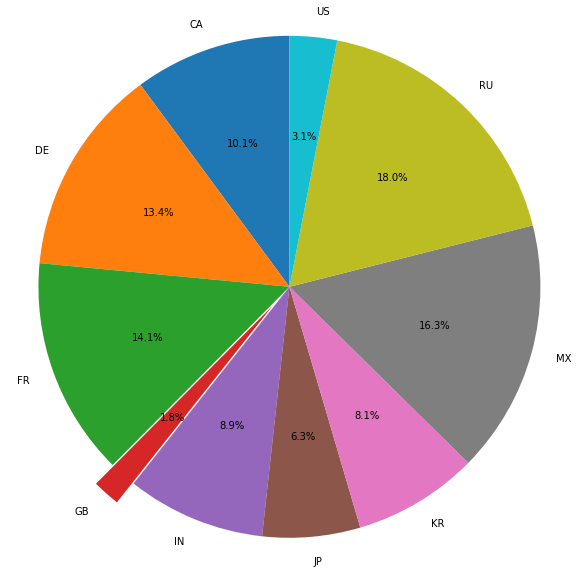

In [8]:
labels = my_df.groupby(['country']).count().index
sizes = my_df.groupby(['country']).count()['title']
print(sizes)
explode = (0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0)

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, explode=explode, startangle=90)
ax.axis('equal')


# How many likes, dislikes, views and comments get by different countries? 

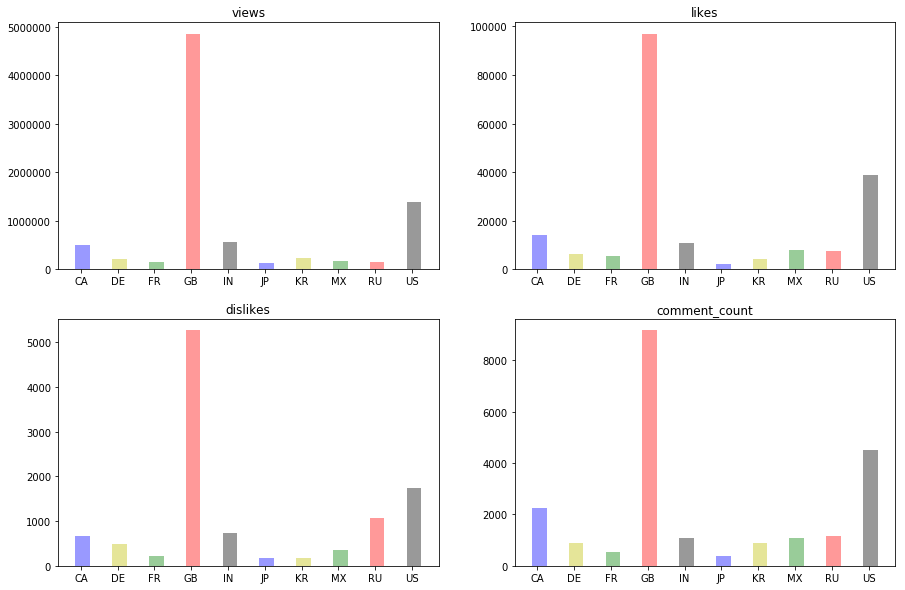

In [9]:
to_int = ['views', 'likes', 'dislikes', 'comment_count']
for column in to_int:
    my_df[column] = my_df[column].astype(int)
    
measures = list()
n_groups = len(country_list)
for i, typ in enumerate(to_int):
    measure = list()
    for c in country_list:
        measure.append(my_df[my_df['country']==c][typ].agg('sum')/len(my_df[my_df['country']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,
                alpha=opacity, color=['b','y','g','r','k'],
                error_kw=error_config)
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(country_list)


**Observation:**
Obviously, four of the graphs share the similar trend in numbers. One possible reason to this is due to the video's trending duration. Enduring trending videos have the advantages in getting more views, likes, dislikes and comments.

# Users like videos from which **CATEGORY** the most?

## From United Kingdom Users : 

Text(0.5,1,'Catogories of trend videos in United Kingdom')

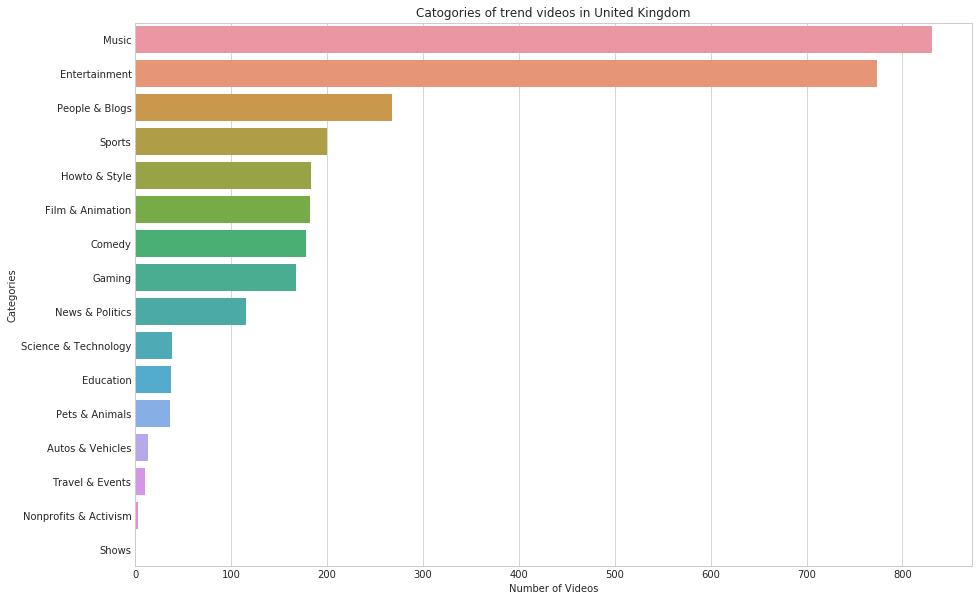

In [11]:
cat_df_gb = my_df[my_df['country']=='GB']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_gb['index'],x=cat_df_gb['category'], data=cat_df_gb,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in United Kingdom")

## From US Users : 

Text(0.5,1,'Catogories of trend videos in US')

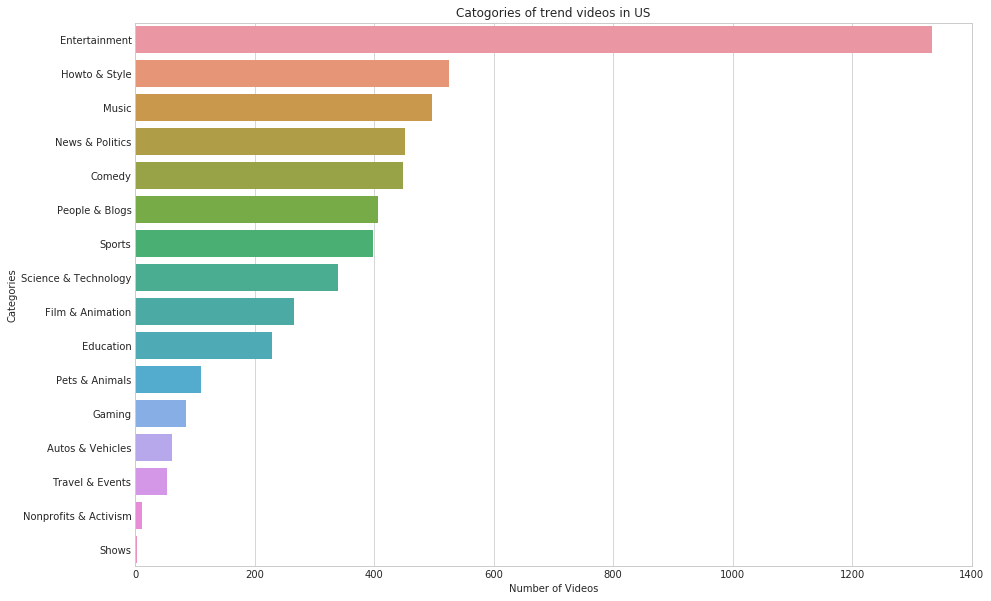

In [12]:
cat_df_us = my_df[my_df['country']=='US']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_us['index'],x=cat_df_us['category'], data=cat_df_us,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in US")

# From Canada Users:

Text(0.5,1,'Catogories of trend videos in CANADA')

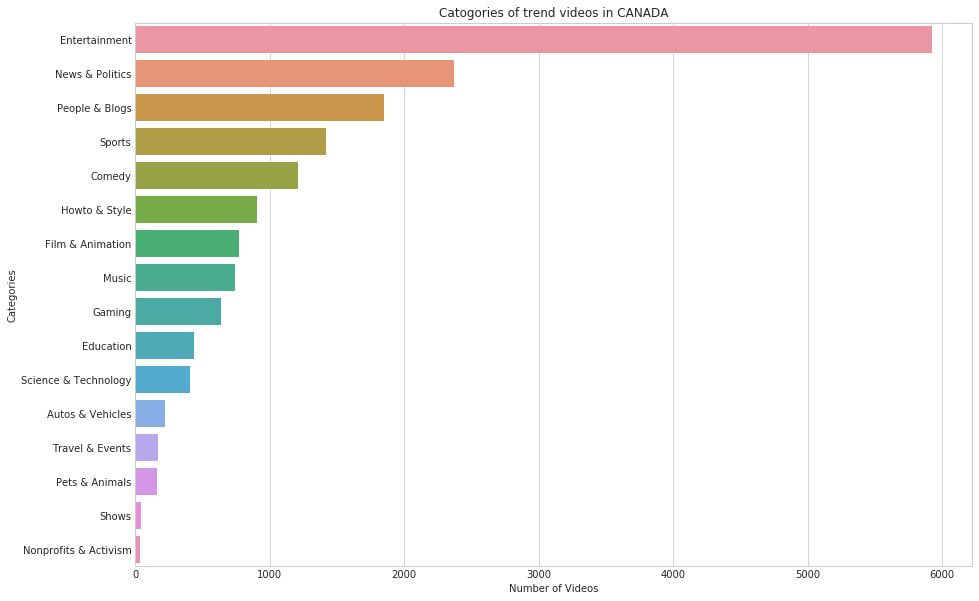

In [13]:
cat_df_ca = my_df[my_df['country']=='CA']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_ca['index'],x=cat_df_ca['category'], data=cat_df_ca,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in CANADA")

# From Germany Users:

Text(0.5,1,'Catogories of trend videos in GERMANY')

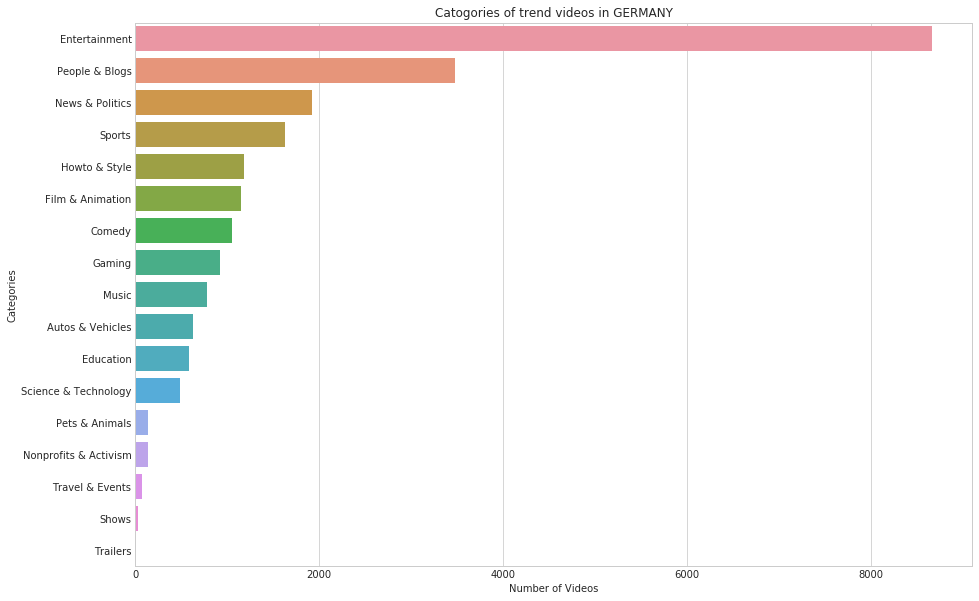

In [14]:
cat_df_de = my_df[my_df['country']=='DE']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_de['index'],x=cat_df_de['category'], data=cat_df_de,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in GERMANY")

# Sentiment analysis on Video's tags 

In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

# Polarity

In [ ]:
MAX_N = 1000

en_stopwords = list(stopwords.words('english'))
de_stopwords = list(stopwords.words('german'))   
fr_stopwords = list(stopwords.words('french'))   
en_stopwords.extend(de_stopwords)
en_stopwords.extend(fr_stopwords)

polarities = list()

for cate in category_list:
    tags_word = my_df[my_df['category']==cate]['tags'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]      
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)

category_list = pd.DataFrame(category_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list,polarities],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")


In [ ]:
def wcloud(data,bgcolor):
    plt.figure(figsize = (20,15))
    cloud = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')

## News & Politics

In [ ]:
tags_word = my_df[my_df['category']=='News & Politics']['tags'].str.lower().str.cat(sep=' ')

tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
word_tokens = word_tokenize(tags_word)
filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
without_single_chr = [word for word in filtered_sentence if len(word) > 2]
cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]

wcloud(cleaned_data_title,'white')

# Entertainment

In [ ]:
tags_word = my_df[my_df['category']=='Entertainment']['tags'].str.lower().str.cat(sep=' ')

tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
word_tokens = word_tokenize(tags_word)
filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
without_single_chr = [word for word in filtered_sentence if len(word) > 2]
cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]

wcloud(cleaned_data_title,'white')